# Setup

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

# Data

In [28]:
df_distances = pd.read_excel('data/distances.xlsx', sheet_name=0, header=None)

distances = df_distances.iloc[2:, 2:].to_numpy()
print(distances)

[[16.16 24.08 24.32 21.12]
 [19.0 26.47 27.24 17.33]
 [25.29 32.49 33.42 12.25]
 [0.0 7.93 8.31 36.12]
 [3.07 6.44 7.56 37.37]
 [1.22 7.51 8.19 36.29]
 [2.8 10.31 10.95 33.5]
 [2.87 5.07 5.67 38.8]
 [3.8 8.01 7.41 38.16]
 [12.35 4.52 4.35 48.27]
 [11.11 3.48 2.97 47.14]
 [21.99 22.02 24.07 39.86]
 [8.82 3.3 5.36 43.31]
 [7.93 0 2.07 43.75]
 [9.34 2.25 1.11 45.43]
 [8.31 2.07 0.0 44.43]
 [7.31 2.44 1.11 43.43]
 [7.55 0.75 1.53 43.52]
 [11.13 18.41 19.26 25.4]
 [17.49 23.44 24.76 23.21]
 [11.03 18.93 19.28 25.43]
 [36.12 43.75 44.43 0.0]]


In [29]:
df_workloads = pd.read_csv('data/bricks_index_values.csv')

workloads = df_workloads['index_value'].to_numpy()
print(workloads)

[0.1609 0.1164 0.1026 0.1516 0.0939 0.132  0.0687 0.093  0.2116 0.2529
 0.0868 0.0828 0.0975 0.8177 0.4115 0.3795 0.071  0.0427 0.1043 0.0997
 0.1698 0.2531]


In [30]:
# Current assignment (c_ij)
current_assignment = np.zeros((22, 4))
current_assignment[[0, 1, 2, 3, 4], 0] = 1
current_assignment[[5, 6, 7, 8], 1] = 1
current_assignment[[9, 10, 11, 12, 13], 2] = 1
current_assignment[[14, 15, 16, 17, 18, 19, 20, 21], 3] = 1

In [31]:
workload_min = 0.8
workload_max = 1.2

# Step 1
## Two mono-objective linear optimization models

### Models:

1. **Distance Minimization**: Minimize the total travel distance for Sales Representatives (SRs).
2. **Disruption Minimization**: Minimize disruption by assigning bricks as close as possible to their current SR assignments.

---

### Model Parameters

Let:

- $I = \{1, 2, \dots, 22\}$: Set of bricks.  
- $J = \{1, 2, 3, 4\}$: Set of Sales Representatives (SRs).  
- $d_{ij}$: Distance between SR $j$'s center brick and brick $i$.  
- $w_i$: Workload index value of brick $i$.  
- $x_{ij}$: Binary decision variable (1 if brick $i$ is assigned to SR $j$, 0 otherwise).  
- $c_{ij}$: Binary parameter (1 if brick $i$ is currently assigned to SR $j$, 0 otherwise).   

---

### Objective 1: Distance Minimization

$$
\text{Minimize } Z_1 = \sum_{i \in I} \sum_{j \in J} d_{ij} \cdot x_{ij}
$$

---

### Objective 2: Disruption Minimization

$$
\text{Minimize } Z_2 = \sum_{i \in I} \sum_{j \in J} w_i \cdot |x_{ij} - c_{ij}|
$$

where $|x_{ij} - c_{ij}|$ accounts for reassignment.

---

### Constraints

1. **Each brick is assigned to exactly one SR**:  
$$
\sum_{j \in J} x_{ij} = 1, \quad \forall i \in I
$$

2. **Workload constraints**: The workload for each SR must be balanced between 0.8 and 1.2:  
$$
0.8 \leqslant \sum_{i \in I} w_i \cdot x_{ij} \leqslant 1.2, \quad \forall j \in J
$$

3. **Binary nature of the decision variable**:  
$$
x_{ij} \in \{0, 1\}, \quad \forall i \in I, \, \forall j \in J
$$

---

In [11]:
bricks = range(22)
SRs = range(4)

In [12]:
model_distance = Model("Distance Minimization")

# Decision Variables
x = model_distance.addVars(22, 4, vtype=GRB.BINARY, name="x")

model_distance.setObjective(quicksum(distances[i][j] * x[i, j] for i in bricks for j in SRs), GRB.MINIMIZE)

# Constraints
# Each brick is assigned to exactly one SR
for i in bricks:
    model_distance.addConstr(quicksum(x[i, j] for j in SRs) == 1)
# Workload constraints for each SR
for j in SRs:
    model_distance.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) >= workload_min)
    model_distance.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) <= workload_max)

model_distance.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 30 rows, 88 columns and 264 nonzeros
Model fingerprint: 0x0d18ee90


Variable types: 0 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [8e-01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 397.6800000
Presolve time: 0.01s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 1.488330e+02, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  148.83305    0    6  397.68000  148.83305  62.6%     -    0s
H    0     0                     181.0200000  148.83305  17.8%     -    0s
H    0     0                     154.6000000  148.83305  3.73%     -    0s
     0     0  148.83305    0    6  154.60000  148.83305  3.73%     -    0s

Explored 1 nodes (25 simplex iterations) in 0.03 seconds (0.00 work units)
Thre

In [13]:
if model_distance.status == GRB.OPTIMAL:
    print("Optimal Distance Objective Value:", model_distance.objVal)
    for i in bricks:
        for j in SRs:
            if x[i, j].X > 0.5:
                print(f"Brick {i+1} is assigned to SR {j+1}")
else:
    print("No optimal solution found.")

Optimal Distance Objective Value: 154.59999999999997
Brick 1 is assigned to SR 4
Brick 2 is assigned to SR 4
Brick 3 is assigned to SR 4
Brick 4 is assigned to SR 1
Brick 5 is assigned to SR 1
Brick 6 is assigned to SR 1
Brick 7 is assigned to SR 1
Brick 8 is assigned to SR 1
Brick 9 is assigned to SR 1
Brick 10 is assigned to SR 3
Brick 11 is assigned to SR 2
Brick 12 is assigned to SR 1
Brick 13 is assigned to SR 2
Brick 14 is assigned to SR 2
Brick 15 is assigned to SR 3
Brick 16 is assigned to SR 3
Brick 17 is assigned to SR 3
Brick 18 is assigned to SR 2
Brick 19 is assigned to SR 1
Brick 20 is assigned to SR 1
Brick 21 is assigned to SR 4
Brick 22 is assigned to SR 4


In [14]:
model_disruption = Model("Disruption Minimization")

x = model_disruption.addVars(22, 4, vtype=GRB.BINARY, name="x")

model_disruption.setObjective(quicksum(workloads[i] * (x[i, j] - current_assignment[i, j]) * (x[i, j] - current_assignment[i, j])
                                       for i in bricks for j in SRs), GRB.MINIMIZE)

# Constraints
# Each brick is assigned to exactly one SR
for i in bricks:
    model_disruption.addConstr(quicksum(x[i, j] for j in SRs) == 1)
# Workload constraints for each SR
for j in SRs:
    model_disruption.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) >= workload_min)
    model_disruption.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) <= workload_max)

model_disruption.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 30 rows, 88 columns and 264 nonzeros
Model fingerprint: 0x43ed21dd
Model has 88 quadratic objective terms
Variable types: 0 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [9e-02, 2e+00]
  QObjective range [9e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 6.7436000
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 9.386000e-01, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestB

In [15]:
if model_disruption.status == GRB.OPTIMAL:
    print("Optimal Disruption Objective Value:", model_disruption.objVal)
    for i in bricks:
        for j in SRs:
            if x[i, j].X > 0.5:
                print(f"Brick {i+1} is assigned to SR {j+1}")
else:
    print("No optimal solution found.")

Optimal Disruption Objective Value: 1.020199999999999
Brick 1 is assigned to SR 1
Brick 2 is assigned to SR 1
Brick 3 is assigned to SR 1
Brick 4 is assigned to SR 1
Brick 5 is assigned to SR 1
Brick 6 is assigned to SR 2
Brick 7 is assigned to SR 2
Brick 8 is assigned to SR 2
Brick 9 is assigned to SR 2
Brick 10 is assigned to SR 3
Brick 11 is assigned to SR 1
Brick 12 is assigned to SR 2
Brick 13 is assigned to SR 3
Brick 14 is assigned to SR 3
Brick 15 is assigned to SR 4
Brick 16 is assigned to SR 4
Brick 17 is assigned to SR 2
Brick 18 is assigned to SR 4
Brick 19 is assigned to SR 4
Brick 20 is assigned to SR 1
Brick 21 is assigned to SR 2
Brick 22 is assigned to SR 4


##  Epsilon-constraint scheme： all non-dominated solutions

In [16]:
def solve_epsilon_constraint(epsilon, workload_min, workload_max):
    model = Model("Epsilon-Constraint")

    x = model.addVars(22, 4, vtype=GRB.BINARY, name="x")

    distance = quicksum(distances[i, j] * x[i, j] for i in bricks for j in SRs)
    disruption = quicksum(workloads[i] * (x[i, j] - current_assignment[i, j]) * (x[i, j] - current_assignment[i, j]) 
                          for i in bricks for j in SRs)

    model.setObjective(distance, GRB.MINIMIZE)
    model.addConstr(disruption <= epsilon)

    # Constraints
    # Each brick is assigned to exactly one SR
    for i in bricks:
        model.addConstr(quicksum(x[i, j] for j in SRs) == 1)
    # Workload constraints for each SR
    for j in SRs:
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) >= workload_min)
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) <= workload_max)

    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        return model.objVal, disruption.getValue(), [(i, j) for i in bricks for j in SRs if x[i, j].X > 0.5]
    return None, None, None

In [17]:
# Function to filter weakly non-dominated solutions
def filter_non_dominated(solutions):
    non_dominated = []
    for i, (epsilon_i, dist_i, disp_i, assign_i) in enumerate(solutions):
        dominated = False
        for j, (epsilon_j, dist_j, disp_j, assign_j) in enumerate(solutions):
            if i != j and dist_j <= dist_i and disp_j <= disp_i:
                dominated = True
                break
        if not dominated:
            non_dominated.append((epsilon_i, dist_i, disp_i, assign_i))
    return non_dominated

In [18]:
workload_ranges = [(0.8, 1.2), (0.85, 1.15), (0.9, 1.1)]

In [19]:
all_results = {}
variant_epsilon = 0.1

for workload_min, workload_max in workload_ranges:
    solutions = []
    epsilon = np.inf  # Start with epsilon as infinity
    
    while True:
        distance, disruption, assignment = solve_epsilon_constraint(epsilon, workload_min, workload_max)
        if distance is not None:
            solutions.append((epsilon, distance, disruption, assignment))
            epsilon = disruption - variant_epsilon
        else:
            break

    # non_dominated_solutions = solutions
    non_dominated_solutions = filter_non_dominated(solutions)
    all_results[(workload_min, workload_max)] = non_dominated_solutions

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 30 rows, 88 columns and 264 nonzeros
Model fingerprint: 0xf51655c4
Model has 1 quadratic constraint
Variable types: 0 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  QMatrix range    [4e-02, 8e-01]
  QLMatrix range   [9e-02, 2e+00]
  Objective range  [8e-01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
  QRHS range       [1e+100, inf]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)
Found heuristic solution: objective 212.9100000

Root relaxation: objective 1.488330e+02, 25 

In [20]:
for (workload_min, workload_max), solutions in all_results.items():
    print(f"\nWorkload constraints: [{workload_min}, {workload_max}]")
    print("Epsilon-Constraint Non-Dominated Results:")
    for epsilon, dist, disp, assignments in solutions:
        print(f"Epsilon: {epsilon:.2f}, Distance: {dist:.2f}, Disruption: {disp:.2f}")
        # print("Assignments:")
        # for brick, sr in assignments:
        #     print(f"  Brick {brick+1} -> SR {sr+1}")


Workload constraints: [0.8, 1.2]
Epsilon-Constraint Non-Dominated Results:
Epsilon: inf, Distance: 154.60, Disruption: 6.16
Epsilon: 6.06, Distance: 155.42, Disruption: 5.98
Epsilon: 5.88, Distance: 157.62, Disruption: 5.80
Epsilon: 5.70, Distance: 159.31, Disruption: 5.03
Epsilon: 4.93, Distance: 159.54, Disruption: 4.85
Epsilon: 4.75, Distance: 159.88, Disruption: 4.52
Epsilon: 4.42, Distance: 160.70, Disruption: 4.35
Epsilon: 4.25, Distance: 162.90, Disruption: 4.16
Epsilon: 4.06, Distance: 168.62, Disruption: 3.96
Epsilon: 3.86, Distance: 173.35, Disruption: 3.74
Epsilon: 3.64, Distance: 175.73, Disruption: 3.62
Epsilon: 3.52, Distance: 177.93, Disruption: 3.43
Epsilon: 3.33, Distance: 184.81, Disruption: 3.20
Epsilon: 3.10, Distance: 188.38, Disruption: 3.01
Epsilon: 2.91, Distance: 194.67, Disruption: 2.75
Epsilon: 2.65, Distance: 197.50, Disruption: 2.57
Epsilon: 2.47, Distance: 202.41, Disruption: 2.42
Epsilon: 2.32, Distance: 203.79, Disruption: 2.30
Epsilon: 2.20, Distance: 

### Visual representation

In [21]:
def plot_decision_space(results):
    plt.figure(figsize=(8, 6))
    
    for (workload_min, workload_max), solutions in results.items():
        distances = [dist for _, dist, _, _ in solutions]       # X-axis: Distance
        disruptions = [disp for _, _, disp, _ in solutions]     # Y-axis: Disruption
        
        plt.scatter(distances, disruptions, label=f"[{workload_min}, {workload_max}]")
    
    plt.title("Non-Dominated Solutions in the Decision Space")
    plt.xlabel("Distance (f₁)")
    plt.ylabel("Disruption (f₂)")
    plt.legend(title="Workload Ranges")
    plt.grid(True)
    plt.show()

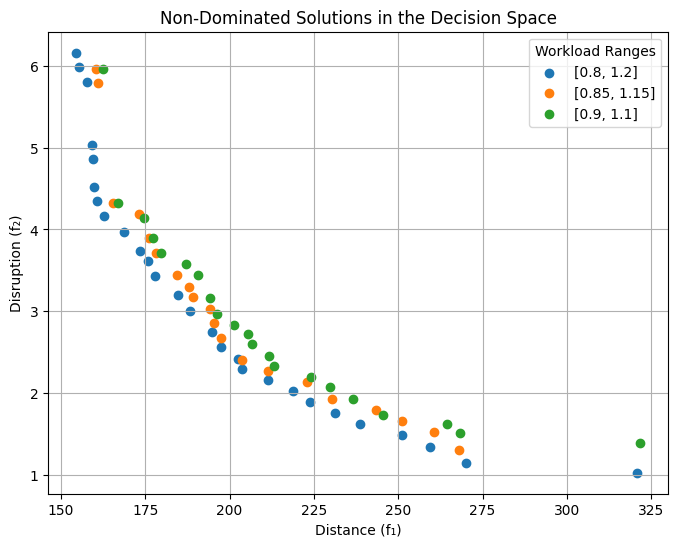

In [22]:
plot_decision_space(all_results)

### Using the model to solve 100 bricks and 10 SRs

In [23]:
# 

# Step 2
## Partially Assigning Bricks 

### 1. Decision Variables:
- Replace the binary variable $x_{ij} \in \{0, 1\}$ with a continuous variable $x_{ij} \in [0, 1]$, representing the proportion of brick $i$ assigned to SR $j$.

### 2. Constraints:
- Update the "assignment constraint" so that the sum of proportions assigned to all SRs equals 1:
  $$
  \sum_{j \in J} x_{ij} = 1, \quad \forall i \in I
  $$
  This ensures that each brick is fully distributed among the SRs, but not necessarily assigned to a single SR.

### 3. Workload Constraints:
- These remain the same:
  $$
  0.8 \leqslant \sum_{i \in I} w_i \cdot x_{ij} \leqslant 1.2, \quad \forall j \in J
  $$

### 4. Objectives:
- The objectives (distance minimization and disruption minimization) remain the same:
  $$
  Z_1 = \sum_{i \in I} \sum_{j \in J} d_{ij} \cdot x_{ij}
  $$
  $$
  Z_2 = \sum_{i \in I} \sum_{j \in J} w_i \cdot |x_{ij} - c_{ij}|
  $$


In [51]:
def solve_partial_assignment(epsilon, workload_min, workload_max):
    model = Model("Partial Assignment")

    x = model.addVars(22, 4, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="x") # Decision variables: x_ij in [0, 1]
    y = model.addVars(22, 4, vtype=GRB.CONTINUOUS, name="y")

    distance = quicksum(distances[i, j] * x[i, j] for i in bricks for j in SRs)
    disruption = quicksum(workloads[i] * y[i, j] for i in bricks for j in SRs)

    model.setObjective(distance, GRB.MINIMIZE)
    model.addConstr(disruption <= epsilon)

    # Constraints
    for i in bricks:
        # Each brick must be fully assigned across SRs
        model.addConstr(quicksum(x[i, j] for j in SRs) == 1)

    for j in SRs:
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) >= workload_min)
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) <= workload_max)

    # Disruption constraints
    for i in bricks:
        for j in SRs:
            model.addConstr(y[i, j] >= x[i, j] - current_assignment[i, j])
            model.addConstr(y[i, j] >= -(x[i, j] - current_assignment[i, j]))

    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        return model.objVal, disruption.getValue(), [(i, j, x[i, j].X) for i in bricks for j in SRs if x[i, j].X > 0]
    else:
        return None, None, None


In [52]:
results_partial = {}
variant_epsilon = 0.1

for workload_min, workload_max in workload_ranges:
    solutions = []
    epsilon = np.inf
    
    while True:
        distance, disruption, assignment = solve_partial_assignment(epsilon, workload_min, workload_max) # change the model
        if distance is not None:
            solutions.append((epsilon, distance, disruption, assignment))
            epsilon = disruption - variant_epsilon
        else:
            break

    # non_dominated_solutions = solutions
    non_dominated_solutions = filter_non_dominated(solutions)
    results_partial[(workload_min, workload_max)] = non_dominated_solutions

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 207 rows, 176 columns and 704 nonzeros
Model fingerprint: 0x44f2ca73
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [8e-01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 181 rows and 88 columns
Presolve time: 0.01s
Presolved: 26 rows, 92 columns, 180 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3473000e+02   1.140000e+00   0.000000e+00      0s
       3    1.4862895e+02   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.486289468e+02
Gu

In [53]:
for (workload_min, workload_max), solutions in results_partial.items():
    print(f"\nWorkload constraints: [{workload_min}, {workload_max}]")
    print("Partially Assignment Results:")
    for epsilon, dist, disp, assignments in solutions:
        print(f"Epsilon: {epsilon:.2f}, Distance: {dist:.2f}, Disruption: {disp:.2f}")


Workload constraints: [0.8, 1.2]
Partially Assignment Results:
Epsilon: inf, Distance: 148.63, Disruption: 6.33
Epsilon: 6.23, Distance: 148.82, Disruption: 6.23
Epsilon: 6.13, Distance: 149.01, Disruption: 6.13
Epsilon: 6.03, Distance: 149.27, Disruption: 6.03
Epsilon: 5.93, Distance: 149.54, Disruption: 5.93
Epsilon: 5.83, Distance: 149.80, Disruption: 5.83
Epsilon: 5.73, Distance: 150.07, Disruption: 5.73
Epsilon: 5.63, Distance: 150.33, Disruption: 5.63
Epsilon: 5.53, Distance: 150.60, Disruption: 5.53
Epsilon: 5.43, Distance: 150.86, Disruption: 5.43
Epsilon: 5.33, Distance: 151.13, Disruption: 5.33
Epsilon: 5.23, Distance: 151.50, Disruption: 5.23
Epsilon: 5.13, Distance: 151.90, Disruption: 5.13
Epsilon: 5.03, Distance: 152.30, Disruption: 5.03
Epsilon: 4.93, Distance: 152.70, Disruption: 4.93
Epsilon: 4.83, Distance: 153.10, Disruption: 4.83
Epsilon: 4.73, Distance: 153.49, Disruption: 4.73
Epsilon: 4.63, Distance: 153.89, Disruption: 4.63
Epsilon: 4.53, Distance: 154.86, Disr

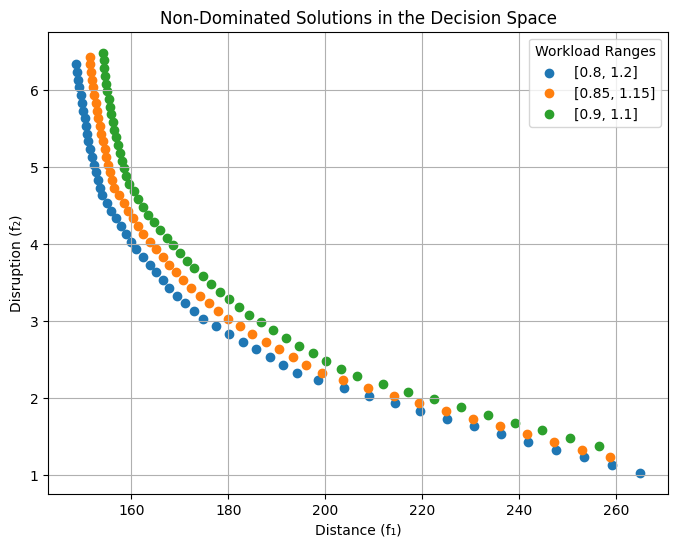

In [54]:
plot_decision_space(results_partial)

- Before Partial Assignment: The solutions exhibit higher flexibility, with more options for both high and low disruption levels.
- After Partial Assignment: The solutions focus on a more practical region of the decision space, balancing distances and disruptions more effectively.

# Step 4

In [32]:
preferences_data = pd.read_excel('data/Preferences.xlsx', sheet_name='DM Preferences')

criteria_values = preferences_data[['distance', 'max_workload', '#changed offices']].values
rankings = preferences_data['rank'].values

In [33]:
print("Criteria Values:")
print(criteria_values)
print("\nRankings:")
print(rankings)

Criteria Values:
[[ 83.7222536    1.06635769   1.        ]
 [ 86.06487029   1.12324265   0.        ]
 [ 89.6639451    1.11419638   1.        ]
 [ 80.18637567   1.22684437   1.        ]
 [ 79.22761378   1.18049994   2.        ]
 [ 75.21489302   1.40483011   0.        ]
 [ 83.30801015   1.47108284   0.        ]
 [ 82.39731414   1.40964798   1.        ]
 [ 81.46646041   1.02921185   4.        ]
 [ 91.78442093   1.08713063   3.        ]
 [103.31869586   1.22381242   0.        ]
 [ 94.12387853   1.30654991   0.        ]
 [117.85792847   1.03242009   2.        ]
 [ 88.98791323   1.26218968   2.        ]
 [ 76.43830663   1.29014786   3.        ]
 [185.90059899   1.10404998   1.        ]
 [ 91.24773431   1.40160377   2.        ]
 [101.50924779   1.18227143   3.        ]
 [118.22552192   1.26511839   1.        ]
 [110.22721834   1.3274603    1.        ]
 [139.69758501   1.03614225   3.        ]
 [129.53077717   1.17472727   2.        ]
 [129.11889303   1.18579896   2.        ]
 [116.87062859   

In [34]:
rank_indices = [rank - 1 for rank in rankings]
pairwise_rankings = [(rank_indices[i], rank_indices[j]) for i in range(len(rank_indices)) for j in range(i + 1, len(rank_indices))]

In [35]:
bricks = range(22)
SRs = range(4)

In [36]:
def solve_partial_assignment_UTA(epsilon, workload_min, workload_max):
    model = Model("Partial Assignment")

    x = model.addVars(22, 4, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="x")  # Decision variables
    y = model.addVars(22, 4, vtype=GRB.CONTINUOUS, name="y")  # Disruption variables

    # Objectives
    distance = quicksum(distances[i, j] * x[i, j] for i in bricks for j in SRs)
    disruption = quicksum(workloads[i] * y[i, j] for i in bricks for j in SRs)

    model.setObjective(distance, GRB.MINIMIZE)
    model.addConstr(disruption <= epsilon)

    # Constraints
    # Each brick must be fully assigned across SRs
    for i in bricks:
        model.addConstr(quicksum(x[i, j] for j in SRs) == 1)

    for j in SRs:
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) >= workload_min)
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) <= workload_max)

    # Disruption constraints
    for i in bricks:
        for j in SRs:
            model.addConstr(y[i, j] >= x[i, j] - current_assignment[i, j])
            model.addConstr(y[i, j] >= -(x[i, j] - current_assignment[i, j]))

    model.optimize()

    if model.status == GRB.OPTIMAL:
        # Extract assignments
        assignments = [(i, j, x[i, j].X) for i in bricks for j in SRs if x[i, j].X > 0]

        # Calculate number of relocated offices
        num_relocated = sum(
            1 for i in bricks for j in SRs if current_assignment[i, j] > 0 and x[i, j].X > 0 and abs(x[i, j].X - current_assignment[i, j]) > 1e-6
        )

        # Calculate workload fairness (variance of workloads across SRs)
        workloads_per_sr = [
            sum(workloads[i] * x[i, j].X for i in bricks) for j in SRs
        ]
        workload_fairness = np.var(workloads_per_sr)  # Variance of workloads

        return model.objVal, disruption.getValue(), num_relocated, workload_fairness, assignments
    else:
        return None, None, None, None, None

In [37]:
# Function to filter weakly non-dominated solutions
def filter_non_dominated_UTA(solutions):
    non_dominated = []
    for i, (dist_i, disp_i, num_relocated_i, workload_fairness_i, assign_i) in enumerate(solutions):
        dominated = False
        for j, (dist_j, disp_j, _, _, _) in enumerate(solutions):
            if i != j and dist_j <= dist_i and disp_j <= disp_i:
                dominated = True
                break
        if not dominated:
            non_dominated.append((dist_i, disp_i, num_relocated_i, workload_fairness_i, assign_i))
    return non_dominated

In [38]:
workload_min = 0.8
workload_max = 1.2

results_partial_UTA = {}
variant_epsilon = 0.1

solutions = []
epsilon = np.inf

while True:
    distance, disruption, num_relocated, workload_fairness, assignments = solve_partial_assignment_UTA(epsilon, workload_min, workload_max)
    if distance is not None:
        solutions.append((distance, disruption, num_relocated, workload_fairness, assignments))
        epsilon = disruption - variant_epsilon
    else:
        break

non_dominated_solutions = filter_non_dominated_UTA(solutions)
results_partial_UTA[(workload_min, workload_max)] = non_dominated_solutions


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 207 rows, 176 columns and 704 nonzeros
Model fingerprint: 0x44f2ca73
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [8e-01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 181 rows and 88 columns
Presolve time: 0.01s
Presolved: 26 rows, 92 columns, 180 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3473000e+02   1.140000e+00   0.000000e+00      0s
       3    1.4862895e+02   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.486289468e+02
Gu

In [39]:
non_dominated_solutions_UTA = []

for solution in results_partial_UTA[(workload_min, workload_max)]:
    distance, disruption, num_relocated, workload_fairness, assignment = solution
    non_dominated_solutions_UTA.append([distance, workload_fairness, num_relocated, assignment])

In [40]:
for idx, (distance, fairness, relocated, _) in enumerate(non_dominated_solutions_UTA, start=1):
    print(f"Solution {idx}: Total Distance = {distance:.2f}, Workload Fairness = {fairness:.2f}, "
          f"Number of Relocated Offices = {relocated}")

Solution 1: Total Distance = 148.63, Workload Fairness = 0.04, Number of Relocated Offices = 1
Solution 2: Total Distance = 148.82, Workload Fairness = 0.03, Number of Relocated Offices = 1
Solution 3: Total Distance = 149.01, Workload Fairness = 0.03, Number of Relocated Offices = 1
Solution 4: Total Distance = 149.27, Workload Fairness = 0.03, Number of Relocated Offices = 1
Solution 5: Total Distance = 149.54, Workload Fairness = 0.03, Number of Relocated Offices = 1
Solution 6: Total Distance = 149.80, Workload Fairness = 0.03, Number of Relocated Offices = 1
Solution 7: Total Distance = 150.07, Workload Fairness = 0.03, Number of Relocated Offices = 1
Solution 8: Total Distance = 150.33, Workload Fairness = 0.03, Number of Relocated Offices = 1
Solution 9: Total Distance = 150.60, Workload Fairness = 0.03, Number of Relocated Offices = 1
Solution 10: Total Distance = 150.86, Workload Fairness = 0.03, Number of Relocated Offices = 1
Solution 11: Total Distance = 151.13, Workload Fa

In [41]:
uta_criteria = [solution[:3] for solution in non_dominated_solutions_UTA]

In [42]:
n_criteria = 3
n_alternatives = len(criteria_values)
epsilon_mono = 1e-4
epsilon_rank = 1e-4
L_max = 10
breakpoints = {i: np.linspace(min(criteria_values[:, i]), max(criteria_values[:, i]), L_max) for i in range(n_criteria)}

In [43]:
def calculate_solution_utility(solution, piecewise_utilities, breakpoints, n_criteria):
    total_utility = 0
    for i in range(n_criteria):
        for j in range(len(breakpoints[i]) - 1):
            if breakpoints[i][j] <= solution[i] < breakpoints[i][j + 1]:
                slope = (piecewise_utilities[i][j + 1] - piecewise_utilities[i][j]) / (
                    breakpoints[i][j + 1] - breakpoints[i][j]
                )
                total_utility += piecewise_utilities[i][j] + slope * (solution[i] - breakpoints[i][j])
    return total_utility

In [44]:
model = Model("UTA")

u = {i: model.addVars(n_alternatives, lb=0, ub=1/n_criteria, name=f"u_{i}") for i in range(n_criteria)}
sigma_plus = model.addVars(n_alternatives, lb=0, name="sigma_plus")
sigma_minus = model.addVars(n_alternatives, lb=0, name="sigma_minus")

# Normalization constraints
for i in range(n_criteria):
    model.addConstr(u[i][0] == 0, name=f"Utility_Zero_{i}")
    model.addConstr(u[i][n_alternatives - 1] == 1/n_criteria, name=f"Utility_1/3_{i}")
    for k in range(n_alternatives - 1):
        model.addConstr(u[i][k + 1] - u[i][k] >= epsilon_mono, name=f"Piecewise_{i}_{k}")  # Monotonicity

# Ranking constraints
for better, worse in pairwise_rankings:
    better_utility = quicksum(
        u[i][j] * (criteria_values[better, i] - breakpoints[i][j])
        for i in range(n_criteria)
        for j in range(len(breakpoints[i]) - 1)
        if breakpoints[i][j] <= criteria_values[better, i] < breakpoints[i][j + 1]
    )
    worse_utility = quicksum(
        u[i][j] * (criteria_values[worse, i] - breakpoints[i][j])
        for i in range(n_criteria)
        for j in range(len(breakpoints[i]) - 1)
        if breakpoints[i][j] <= criteria_values[worse, i] < breakpoints[i][j + 1]
    )
    model.addConstr(
        better_utility + sigma_minus[better] - sigma_plus[better]
        >= worse_utility + sigma_minus[worse] - sigma_plus[worse] + epsilon_rank,
        name=f"Strict_Preference_{better}_{worse}",
    )

model.setObjective(quicksum(sigma_plus[j] + sigma_minus[j] for j in range(n_alternatives)), GRB.MINIMIZE)

model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 861 rows, 195 columns and 6661 nonzeros
Model fingerprint: 0x4e83f891
Coefficient statistics:
  Matrix range     [7e-04, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e-01, 3e-01]
  RHS range        [1e-04, 3e-01]
Presolve removed 106 rows and 102 columns
Presolve time: 0.00s
Presolved: 755 rows, 93 columns, 5919 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.050957e-01   0.000000e+00      0s
     144    9.8828071e-02   0.000000e+00   0.000000e+00      0s

Solved in 144 iterations and 0.01 seconds (0.01 work units)
Optimal objective  9.882807106e-02


Optimal solution found for UTA.


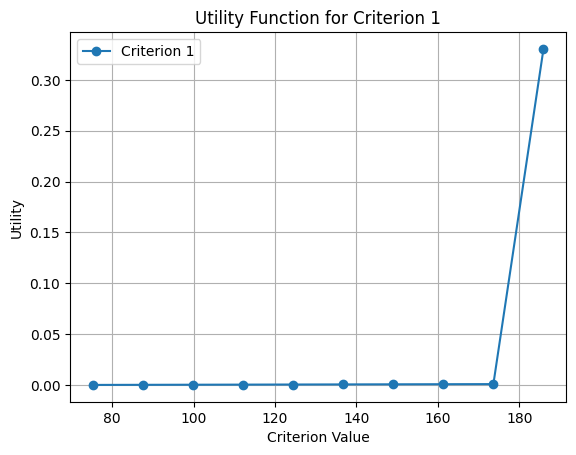

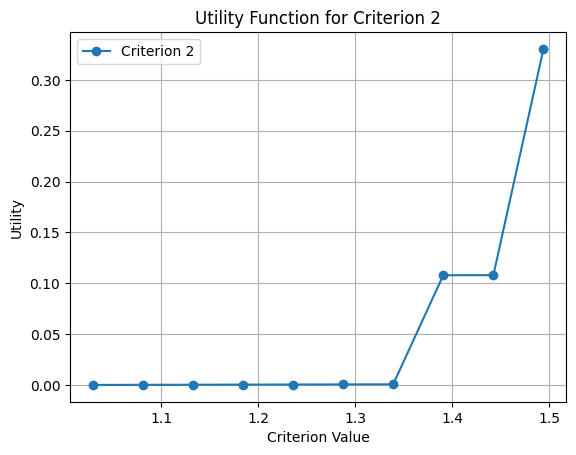

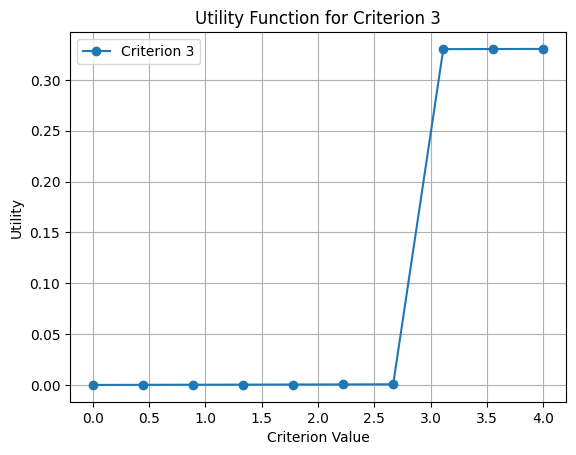

Best solution: [185.77282189224653, 0.039999999999999994, 4] with utility: 0.3270
Best solution assignment: [(0, 0, 1.0), (1, 0, 0.5738831615120146), (1, 3, 0.4261168384879854), (2, 3, 1.0), (3, 0, 1.0), (4, 0, 1.0), (5, 0, 0.5378787878787995), (5, 1, 0.4621212121212005), (6, 0, 1.0), (7, 1, 1.0), (8, 1, 1.0), (9, 2, 1.0), (10, 2, 1.0), (11, 0, 1.0), (12, 1, 0.5630769230769235), (12, 2, 0.43692307692307664), (13, 2, 1.0), (14, 1, 0.6957472660996391), (14, 3, 0.30425273390036084), (15, 1, 1.0), (16, 1, 1.0), (17, 1, 1.0), (18, 0, 1.0), (19, 3, 1.0), (20, 3, 1.0), (21, 3, 1.0)]


In [45]:
if model.status == GRB.OPTIMAL:
    print("Optimal solution found for UTA.")

    # Extract utility function
    piecewise_utilities = {}
    for i in range(n_criteria):
        piecewise_utilities[i] = [u[i][j].X for j in range(len(breakpoints[i]))]

    # Plot piecewise utilities
    for i in range(n_criteria):
        plt.figure()
        plt.plot(breakpoints[i], piecewise_utilities[i], marker="o", label=f"Criterion {i + 1}")
        plt.title(f"Utility Function for Criterion {i + 1}")
        plt.xlabel("Criterion Value")
        plt.ylabel("Utility")
        plt.grid(True)
        plt.legend()
        plt.show()

    # Solution utilities
    solution_utilities = [
        (solution, calculate_solution_utility(solution, piecewise_utilities, breakpoints, n_criteria))
        for solution in uta_criteria
    ]

    # # Print all solutions with their utilities
    # print("Solutions and their utilities:")
    # for solution, utility in solution_utilities:
    #     print(f"Solution: {solution}, Utility: {utility:.4f}")

    best_solution = max(solution_utilities, key=lambda x: x[1])

    best_solution_assign = non_dominated_solutions_UTA[uta_criteria.index(best_solution[0])] # retrieve the assignment
    best_assignment = best_solution_assign[-1]

    print(f"Best solution: {best_solution[0]} with utility: {best_solution[1]:.4f}")
    print(f"Best solution assignment: {best_assignment}")

else:
    print("No optimal solution found for UTA.")